# Notes
1. [x] Use DOT notation and Dictionary Indexing for fields in records.
1. [ ] Be sure to test by using at least one field that has be renamed in Admin.  This may catch problems if SPARCL erroneosly uses Internal instead of Science field names.
1. [ ] Change SparcClient call to use _PAT instead of _DEV.  

In [110]:
import sparcl.client
import sparcl.utils as ut
from collections import defaultdict

In [2]:
#client = sparcl.client.SparclClient(url=sparcl.client._DEV, verbose=True)
client = sparcl.client.SparclClient(url=sparcl.client._DEV, verbose=False)
client 

/home/pothiers/sandbox/sparclclient/sparcl/client.py:278: UserWarning: Implementation ignores that fact that a
        single Science Field Name might map to MULTIPLE Internal Field Names
        within a single Data Set.  If this is the case (see Admin)
        results may be unpredictable!!!
  self.fields = Fields(self.apiurl)


(sparclclient:0.4.0a5.dev4, api:6.0, http://localhost:8030/sparc, verbose=False, connect_timeout=1.1, read_timeout=5400.0)

In [3]:
client.get_default_fields(None)

['flux', 'uuid', 'wavelength']

In [4]:
client.get_default_fields(['BOSS-DR16'])

['flux', 'uuid', 'wavelength']

In [5]:
print(client.get_all_fields(['DESI-edr']))

['FIBER', 'HEALPIX', 'LOCATION', 'MJD', 'PROGRAM', 'RUN2D', 'SURVEY', 'SV_PRIMARY', 'TARGETID', 'TILEID', 'data_release', 'datasetgroup', 'dateobs', 'dateobs_center', 'dec', 'exptime', 'flux', 'instrument', 'ivar', 'mask', 'model', 'ra', 'redshift', 'redshift_err', 'redshift_warning', 'site', 'sky', 'specid', 'specprimary', 'spectype', 'telescope', 'uuid', 'wave_sigma', 'wavelength', 'wavemax', 'wavemin']


In [6]:
print(sorted(client.get_all_fields(['BOSS-DR16']))) 

['FIBERID', 'MJD', 'PLATEID', 'RUN1D', 'RUN2D', 'SPECOBJID', 'TARGETID', 'data_release', 'datasetgroup', 'dateobs', 'dateobs_center', 'dec', 'exptime', 'flux', 'instrument', 'ivar', 'mask', 'model', 'ra', 'redshift', 'redshift_err', 'redshift_warning', 'site', 'sky', 'specid', 'specprimary', 'spectype', 'telescope', 'uuid', 'wave_sigma', 'wavelength', 'wavemax', 'wavemin']


In [7]:
# get sample ids
found = client.find(['uuid', 'data_release'], limit=50)
ids = found.ids
found.info

{'META': {'endpoint': 'sparc/find'},
 'PARAMETERS': {'limit': 50,
  'include': None,
  'offset': 0,
  'json_payload': {'outfields': ['data_release', 'id'], 'search': []}},
 'HEADER': {'id': 'str', 'data_release': 'category'},
 'WARNINGS': ["OFFSET parameter needs SORT but it was not provided. Using default 'id' for sorting"],
 'Count': 6}

In [8]:
# orig=redshift, new=z in DataFields
dr='DESI-edr'
id_desi = [rec['uuid'] for rec in found.records if rec.get('data_release') == dr]
print(f'Found {len(id_desi)} ids from Data Set = {dr}')
results = client.retrieve(id_desi, include=['flux', 'wavelength', 'uuid'], dataset_list=[dr])
results.info

Found 2 ids from Data Set = DESI-edr


{'status': {'success': True,
  'info': 'Successfully found 2 records in dr=DESI-edr'},
 'Count': 2}

### We can use dot notation and dictionary indexing for fields in records.

In [9]:
print(f'dict key access: {len(results.records[0]["flux"])}')
print(f'dict DOT access: {len(results.records[0].flux)}')

dict key access: 7781
dict DOT access: 7781


In [10]:
import sparcl.utils as ut

In [11]:
dd = ut._AttrDict(results.records[0])

In [12]:
dd._dr

'DESI-edr'

In [13]:
specids = [1429831265344501, 1429831265410037]
results = client.retrieve_by_specid(specids, include=['uuid','specid'], verbose=True)
print(results.info)
results.records

Found 2 matches.
Using url="http://localhost:8030/sparc/retrieve/?include=id%2Cspecid&dataset_list=BOSS-DR16%2CDESI-edr%2CSDSS-DR16"
Got response to post in 0.016344383009709418 seconds
Got 2 spectra in 0.02 seconds (122 spectra/sec)
{'success': True, 'info': 'Successfully found 2 records in dr=BOSS-DR16,DESI-edr,SDSS-DR16'}
Got 2 records.
{'status': {'success': True, 'info': 'Successfully found 2 records in dr=BOSS-DR16,DESI-edr,SDSS-DR16'}, 'Count': 2}


[{'specid': 1429831265344501,
  'uuid': '4d62c9bc-f72b-47b3-a11e-0231a6e7e4a2',
  '_dr': 'BOSS-DR16'},
 {'specid': 1429831265410037,
  'uuid': 'fbef651a-e6cb-48b5-a1a9-2a3860f2c732',
  '_dr': 'BOSS-DR16'}]

## Join request and response on id

In [119]:
ids = list(ids)
common_flds = ['data_release','dec','ra','redshift','flux','wavelength','spectype','uuid']
res_common = client.retrieve(ids, include=common_flds)
res_boss = client.retrieve(ids, include=['uuid','SPECOBJID'], dataset_list=['BOSS-DR16', 'SDSS-DR16'])
res_desi = client.retrieve(ids, include=['uuid','SURVEY'], dataset_list=['DESI-edr'])

joined_records = defaultdict(dict) # dict[uuid] = dict[BOSS3, DESI2]
# for uuid in ids:
#     joined_records[uuid]['BOSS-3'] = res_boss.records
#     joined_records[uuid]['DESI-3'] = res_desi.records

for rec in res_common.records:
    joined_records[rec.uuid]['COMMON'] = rec
for rec in res_boss.records:
    joined_records[rec.uuid]['BOSS'] = rec
for rec in res_desi.records:
    joined_records[rec.uuid]['DESI'] = rec
    
joined = ut._AttrDict(joined_records)
#print(dict(joined))
#joined[ids[0]]['COMMON']['redshift'], joined[ids[0]]['BOSS']['SPECOBJID'], joined[ids[0]].get('DESI')
joined[ids[0]].COMMON.redshift, joined[ids[0]].BOSS.SPECOBJID, joined[ids[0]].get('DESI')

/tmp/ipykernel_160350/1194927974.py:4: UserWarning: 2 out of the 6 requested uuids have no records available in the SPARC database. Use "client.missing_uuids()" to get a list of the 2 unavailable uuids.
  res_boss = client.retrieve(ids, include=['uuid','SPECOBJID'], dataset_list=['BOSS-DR16', 'SDSS-DR16'])
/tmp/ipykernel_160350/1194927974.py:5: UserWarning: 4 out of the 6 requested uuids have no records available in the SPARC database. Use "client.missing_uuids()" to get a list of the 4 unavailable uuids.
  res_desi = client.retrieve(ids, include=['uuid','SURVEY'], dataset_list=['DESI-edr'])


(0.000504141731653363, 2997179987334817792, None)

## Use Case: ~~Favorite Data Set list (ID Priority)~~
**Cannot not implement this use case.**
This is because Requirements say "Discovery for core fields only".  This use-case needs to use an AUX field in a constraint!

I have my **favorite Data Set list**. I use `client.find()` over each DR separately because each DR has a different *special field I use in my constraints*. I combine multi-find results into one `id_list`.  I only need fields that are common to all my DRs.  Using
   `results = client.retrieve(id_list)`
   with *ID Priority*, I get `results` that contains a list of homogeneous records.


In [14]:
# # Find is only required to work with CORE fields !!!
# # Therefore only CORE field names are allowed to be used
# # in OUTFIELDS and CONSTRAINTS.

# def find_fav(ds, flds): # => uuid_list
#     ids = sorted(client.find(['uuid'], constraints=[['data_release', ds]]).ids)
#     got = client.retrieve(ids, include=['uuid', *flds], dataset_list=[ds])
#     return ids, got

# ids_boss, got_boss = find_fav('BOSS-DR16', ['PLATEID'])
# ids_desi, got_desi= find_fav('DESI-edr', ['LOCATION'])

# print()
# print(f'BOSS ids={ids_boss}')
# print(f'BOSS records(2)={got_boss.records[:2]}')

# print()
# print(f'DESI ids={ids_desi}')
# print(f'DESI records(2)={got_desi.records[:2]}')

In [15]:
# fav_datasets = ['BOSS-DR16','DESI-edr']
# common = ['flux', 'uuid', 'data_release', 'exptime']
# # Find AUX fields for each in http://sparc1.datalab.noirlab.edu:8000/sparc/sfc/
# aux_boss = ['PLATEID']
# ids_boss = sorted(client.find(['uuid', 'PLATEID'], constraints=[['data_release', 'BOSS-DR16']]).ids)
# print(f'BOSS ids = {ids_boss}')

# aux_desi = ['LOCATION']
# ids_desi = sorted(client.find(['uuid'], constraints=[['data_release', 'DESI-edr']]).ids)
# print(f'DESI id count = {ids_desi}')

## Use Case: Required plus Optional fields

I don't care about DRs but there are **some fields that are required** for my work. **Other fields are optional**.  I want the optional fields if they are available without making my records heterogeneous. 

In [54]:
req_flds = ['SPECOBJID', 'ra', 'dec', 'redshift', 'flux', 'wavelength']
opt_flds = ['RUN1D', 'RUN2D', 'SURVEY']

req_datasets = [dr for dr in client.fields.all_drs if set(req_flds).issubset(client.fields.all_retrieve_fields([dr]))]
req_datasets

['BOSS-DR16', 'SDSS-DR16']

In [61]:
avail = client.fields.all_retrieve_fields(req_datasets)  # available in the DataSets that contain my required fields
avail_opt = set(opt_flds).intersection(avail)
avail_opt

{'RUN1D', 'RUN2D'}

In [66]:
res = client.retrieve(ids, include=[*req_flds, *avail_opt], dataset_list=req_datasets)
print(f'Fields in my homogeneous list of records: {sorted(res.records[0].keys())}')
len(res.records)

Fields in my homogeneous list of records: ['RUN1D', 'RUN2D', 'SPECOBJID', '_dr', 'dec', 'flux', 'ra', 'redshift', 'wavelength']


/tmp/ipykernel_160350/1190765182.py:1: UserWarning: 2 out of the 6 requested uuids have no records available in the SPARC database. Use "client.missing_uuids()" to get a list of the 2 unavailable uuids.
  res = client.retrieve(ids, include=[*req_flds, *avail_opt], dataset_list=req_datasets)


4

## Use Case: Complex find yielding Hetergeneous records
I have ids from a complex combination of `client.find()` and DataLab queries. I must have the records associated with all ids.

I want to process a homogeneous set of records using the largest set of common fields I can.  I'm anticipating doing fancy analysis with special fields but I don't exactly what that will entail yet, so I don't want to throw any fields out.

There are *uncommon fields* I've found to be useful.  I want to process the records that have these uncommon fields seperately from the common batch.  I realize all records containing the uncommon fields will have ids that are also associatated with my common batch. I'll join the two batches using the id.


### Generate list of ids from complex Data Discovery
Some ids might come from Data Lab queries.  Some from use of sparcl.find()

In [17]:
# Simulate ids I got from a complex combination of FIND calls.
ids = set()
for ds in client.all_datasets:
    ids.update(client.find(['uuid'], constraints=[['data_release', ds]]).ids[:2])
#client.retrieve(ids, include=['uuid','data_release']).records

### Homogeneous record processing

In [18]:
common_fields = sorted(client.fields.common())

print(f'Fields common to all DataSets: {", ".join(common_fields)}')

Fields common to all DataSets: MJD, RUN2D, TARGETID, data_release, datasetgroup, dateobs, dateobs_center, dec, dirpath, exptime, extra_files, filename, filesize, flux, instrument, ivar, mask, model, ra, redshift, redshift_err, redshift_warning, site, sky, specid, specprimary, spectype, telescope, uuid, wave_sigma, wavelength, wavemax, wavemin


Fields common to all DataSets: MJD, RUN2D, TARGETID, data_release, datasetgroup, dateobs, dateobs_center, dec, dirpath, exptime, extra_files, filename, filesize, flux, instrument, ivar, mask, model, ra, redshift, redshift_err, redshift_warning, site, sky, specid, specprimary, spectype, telescope, uuid, wave_sigma, wavelength, wavemax, wavemin

{'status': {'success': True, 'info': 'Successfully found 6 records in dr=BOSS-DR16,DESI-edr,SDSS-DR16'}, 'Count': 6}


/home/pothiers/sandbox/sparc-notebooks/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


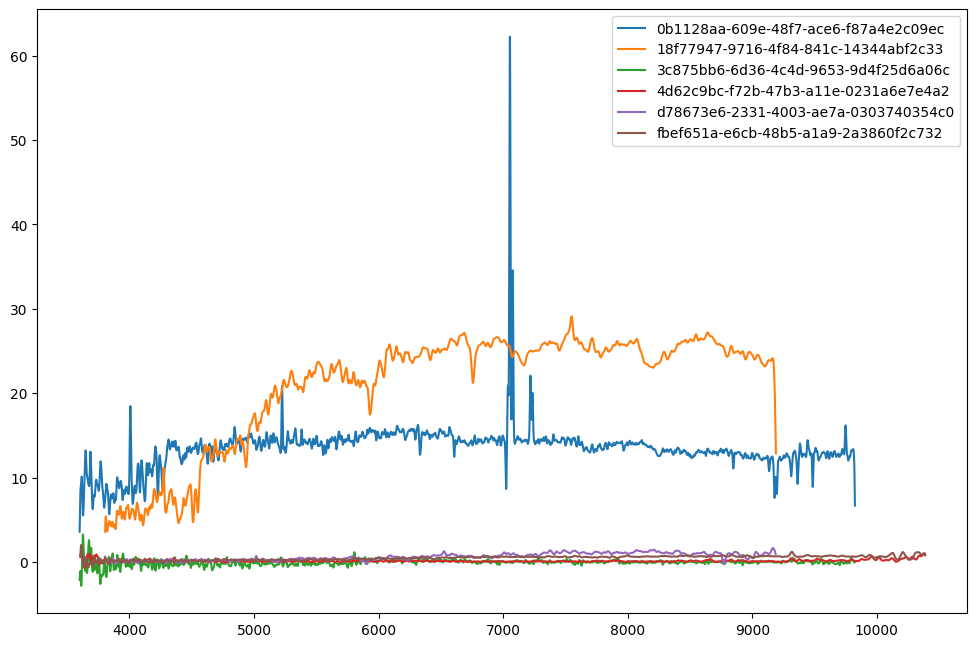

In [19]:
# Simulate processing the homogeneous list of records with common fields.

common_fields = sorted(client.fields.common())
print(f'Fields common to all DataSets: {", ".join(common_fields)}')

res_common = client.retrieve(ids, include=common_fields)
print()
print(res_common.info)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.convolution import convolve, Gaussian1DKernel

handles = []
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
for rec in res_common.records:
    # Plot spectrum smoothed using a 1-D Guassian Kernel
    line, = plt.plot(rec.wavelength, convolve(rec.flux, Gaussian1DKernel(5)), label=rec.uuid)
    handles.append(line)
plt.legend(handles=handles)


### Heterogeneous record processing

In [20]:
# Simulate processing the hetergeneous list of records with varying fields.

# Get records from 2 Data Sets and include a field common to both.
ds_boss = ['SDSS-DR16', 'BOSS-DR16']
com = ['uuid']
res_boss = client.retrieve(ids, include=['SPECOBJID', *com], dataset_list=ds_boss)

ds_desi = ['DESI-edr']
res_desi = client.retrieve(ids, include=['LOCATION', *com], dataset_list=ds_desi)

/tmp/ipykernel_160350/1870177380.py:6: UserWarning: 2 out of the 6 requested uuids have no records available in the SPARC database. Use "client.missing_uuids()" to get a list of the 2 unavailable uuids.
  res_boss = client.retrieve(ids, include=['SPECOBJID', *com], dataset_list=ds_boss)
/tmp/ipykernel_160350/1870177380.py:9: UserWarning: 4 out of the 6 requested uuids have no records available in the SPARC database. Use "client.missing_uuids()" to get a list of the 4 unavailable uuids.
  res_desi = client.retrieve(ids, include=['LOCATION', *com], dataset_list=ds_desi)


At this point we could process `res_boss.records` to do something with SPECOBJID (perhaps join to data we got elsewhere).

In [21]:
res_boss.records

[{'SPECOBJID': 2997176963677841408,
  'uuid': '18f77947-9716-4f84-841c-14344abf2c33',
  '_dr': 'SDSS-DR16'},
 {'SPECOBJID': 8058251292395720704,
  'uuid': '4d62c9bc-f72b-47b3-a11e-0231a6e7e4a2',
  '_dr': 'BOSS-DR16'},
 {'SPECOBJID': 2997179987334817792,
  'uuid': 'd78673e6-2331-4003-ae7a-0303740354c0',
  '_dr': 'SDSS-DR16'},
 {'SPECOBJID': 8058252391907348480,
  'uuid': 'fbef651a-e6cb-48b5-a1a9-2a3860f2c732',
  '_dr': 'BOSS-DR16'}]

In [22]:
res_desi.records

[{'LOCATION': 5291,
  'uuid': '0b1128aa-609e-48f7-ace6-f87a4e2c09ec',
  '_dr': 'DESI-edr'},
 {'LOCATION': 5251,
  'uuid': '3c875bb6-6d36-4c4d-9653-9d4f25d6a06c',
  '_dr': 'DESI-edr'}]

In [23]:
client.missing(ids, dataset_list=ds_boss)

HTTPError: 500 Server Error: Internal Server Error for url: http://localhost:8030/sparc/missing/?dataset_list=SDSS-DR16%2CBOSS-DR16

In [ ]:
res_desi.info